#### Colab Link

    https://colab.research.google.com/drive/1Qu4i5YW0j2E9MJpuy70IWwrEOyNVWYPC?usp=sharing

#### 참고자료
    

    https://www.youtube.com/watch?v=htTt4iPJqMg : Idea Factory KAIST / molecular property prediction
    https://www.youtube.com/watch?v=Ye1nJY7VKGo : 이주용 교수님 / MLP를 이용한 HOMO-LUMO gap 예측 모델 개발

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Mon Aug 21 06:02:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install wandb
!pip install deepchem
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=f0869a8031c72d9097a37140095d8e868b99246264e7afbde03c6a44849a1132
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.

In [ ]:
import argparse
import sys
import yaml
import json
import os
import joblib
import networkx as nx
import pickle as pkl
from tqdm import tqdm
from datetime import datetime, timedelta
import time
import random
import copy
from collections import defaultdict

from prettytable import PrettyTable
import wandb

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

import rdkit
from rdkit.Chem import Draw, AllChem, Descriptors, Lipinski
import deepchem as dc

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_

import torchvision
import torchvision.transforms as transforms

os.environ['TORCH'] = torch.__version__
print(f'Torch ver. : {torch.__version__}')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


Torch ver. : 2.0.1+cu118


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dropout
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool # readout에서 각 노드의 node feature vector들이 남게 되는데, 이걸 하나의 feature로 표현하기 위해 사용

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 56.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
ENTITY = 'rossi22'
TRAIN_PROJECT = 'GCN_LOGP_TRAIN'
SWEEP_PROJECT = 'GCN_LOGP_SWEEP'


DEFAULT_PARAMS = {
    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),

    'disable_rdkit_warnings': True,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 20,
    'period': 1,

    'n_block': 1,
    'n_layer': 1,
    'in_dim': 30,
    'hidden_dim': 64,
    'out_dim': 32,
    'n_head': 1,
    'use_bn': False,
    'sc': None,

    'gat_act': 'gelu',
    'readout_act': 'gelu',
    'gcnnet_act': 'gelu',

    'use_scheduler': True,
    'schd_factor': 0.5,
    'schd_patience': 10,
    'schd_min_lr': 5e-6,

    'supported_atoms': { 'C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I',}
}

ACTIVE_FUNCTION = {
    'gelu': F.gelu,
    'relu': F.relu,
    'elu': F.elu,
    'leaky_relu': F.leaky_relu,
}

# parser = argparse.ArgumentParser()

# for key, value in DEFAULT_PARAMS.items():
#     parser.add_argument('--' + key, default=value)

# args = parser.parse_args('')
# print(args)

# data preprocessing

In [ ]:
def load_smiles(file_name, num_mol, max_num_atoms=1000):
    featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    file_pkl = pkl.load(open(file_name, 'rb'))
    num_mol = min(len(file_pkl), num_mol)

    data_list = []
    y_list = []
    for i in tqdm(range(num_mol), desc='Reading Data'):
        smi = file_pkl[i].strip()
        mol = rdkit.Chem.MolFromSmiles(smi)
        atms = mol.GetAtoms()
        f = featurizer.featurize(mol)

        if f and mol.GetNumAtoms() < max_num_atoms :
            for atm in atms :
                if atm not in DEFAULT_PARAMS['supported_atoms'] :
                    continue

            else :
                logp = Descriptors.MolLogP(mol)
                f[0].kwargs = {}
                data = f[0].to_pyg_graph()
                data.smiles = smi
                data.y = logp
                data_list.append(data)

                y_list.append(logp)
    y_list = torch.Tensor(y_list)
    return data_list, y_list

file_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/ZINC_smi.pkl'
data_list, y_list = load_smiles(file_path, int(2e5))
data_list, y_list

Reading Data: 100%|██████████| 100000/100000 [20:19<00:00, 82.01it/s]


([Data(x=[27, 30], edge_index=[2, 58], edge_attr=[58, 11], smiles='CC1=C(C(=O)N2CCCC2)C(S(=O)(=O)NC2=CC=C(Cl)C=C2F)=C(C)N1C', y=3.4712400000000017),
  Data(x=[13, 30], edge_index=[2, 28], edge_attr=[28, 11], smiles='CC1CCC2=CC=C(Cl)C(Cl)=C2N1', y=3.740000000000002),
  Data(x=[20, 30], edge_index=[2, 42], edge_attr=[42, 11], smiles='CC1=CC=CC(C=CC(=O)C2=C(O)C=C(C)OC2=O)=C1', y=2.858340000000001),
  Data(x=[26, 30], edge_index=[2, 58], edge_attr=[58, 11], smiles='CCN(CC1=NC2=CC=CC=C2C(=O)[NH]1)CC1=C(Cl)C2=CC=CC=C2S1', y=4.8133000000000035),
  Data(x=[28, 30], edge_index=[2, 60], edge_attr=[60, 11], smiles='CC1=CC2=C(C=C1C)[NH]C(=O)C(CCNC(=O)C1=CC=CC(C(F)(F)F)=C1)=C2', y=4.136240000000002),
  Data(x=[33, 30], edge_index=[2, 72], edge_attr=[72, 11], smiles='CC(=O)C1=C(C)[NH]C(C(=O)C(C)N2N=C(C)C(S(=O)(=O)N3CCC4=CC=CC=C43)=C2C)=C1C', y=3.842780000000003),
  Data(x=[32, 30], edge_index=[2, 68], edge_attr=[68, 11], smiles='CC(C)CNC(=O)NC1=CC=C(NC(=O)N2CCCC(C(=O)NCC3CCCO3)C2)C=C1', y=3.00320000

In [ ]:
# # print(f'edge_index.shape : {edge_index.shape}') # 공유결합 개수         [2, 결합 개수]
# print(f'x.shape : {x.shape}')                   # 원자 속성(node_attr)  [원자 개수, 속성 개수]
# print(f'edge_attr.shape : {edge_attr.shape}')   # 공유결합 종류         [결합 개수, 결합 종류]
# print(f'use_pos : {pos}')                       # 3D 좌표 사용 여부
# print(f'edge_weight.shape : {edge_weight.shape}')   # 공유결합 가중치   [결합 개수]

In [ ]:
print(f'data size : {len(data_list)}')
data = data_list[0]
print(data.keys)
print(data.num_node_features)

torch.save(data_list, f'/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/ZINC_data_list.pt')

data size : 100000
<bound method BaseData.keys of Data(x=[27, 30], edge_index=[2, 58], edge_attr=[58, 11], smiles='CC1=C(C(=O)N2CCCC2)C(S(=O)(=O)NC2=CC=C(Cl)C=C2F)=C(C)N1C', y=3.4712400000000017)>
30


# load dataset

In [ ]:
data_list = torch.load('/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/ZINC_data_list.pt')
data_list

[Data(x=[27, 30], edge_index=[2, 58], edge_attr=[58, 11], smiles='CC1=C(C(=O)N2CCCC2)C(S(=O)(=O)NC2=CC=C(Cl)C=C2F)=C(C)N1C', y=3.4712400000000017),
 Data(x=[13, 30], edge_index=[2, 28], edge_attr=[28, 11], smiles='CC1CCC2=CC=C(Cl)C(Cl)=C2N1', y=3.740000000000002),
 Data(x=[20, 30], edge_index=[2, 42], edge_attr=[42, 11], smiles='CC1=CC=CC(C=CC(=O)C2=C(O)C=C(C)OC2=O)=C1', y=2.858340000000001),
 Data(x=[26, 30], edge_index=[2, 58], edge_attr=[58, 11], smiles='CCN(CC1=NC2=CC=CC=C2C(=O)[NH]1)CC1=C(Cl)C2=CC=CC=C2S1', y=4.8133000000000035),
 Data(x=[28, 30], edge_index=[2, 60], edge_attr=[60, 11], smiles='CC1=CC2=C(C=C1C)[NH]C(=O)C(CCNC(=O)C1=CC=CC(C(F)(F)F)=C1)=C2', y=4.136240000000002),
 Data(x=[33, 30], edge_index=[2, 72], edge_attr=[72, 11], smiles='CC(=O)C1=C(C)[NH]C(C(=O)C(C)N2N=C(C)C(S(=O)(=O)N3CCC4=CC=CC=C43)=C2C)=C1C', y=3.842780000000003),
 Data(x=[32, 30], edge_index=[2, 68], edge_attr=[68, 11], smiles='CC(C)CNC(=O)NC1=CC=C(NC(=O)N2CCCC(C(=O)NCC3CCCO3)C2)C=C1', y=3.003200000000001

In [ ]:
train_size = int(len(data_list) * 9.5 // 10)
val_size = (len(data_list)-train_size)//2
print(train_size, val_size)

95000 2500


In [ ]:
random.seed(52)
random.shuffle(data_list)

TRAIN_SET, VAL_SET, TEST_SET = data_list[:train_size], data_list[train_size:train_size+val_size], data_list[train_size+val_size:]
print(len(TRAIN_SET), len(VAL_SET), len(TEST_SET))

95000 2500 2500


In [ ]:
# coefficient z를 학습해서, z와 1-z의 비율로 섞어주는 것.
# z : x와 f(x)의 중요도를 학습하여 더 중요한 값의 비중을 나타냄 (0~1)
class GatedSkipConnection(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        # z : 0 ~ 1 사이의 값
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out

    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)


# https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html
class GraphAttention(torch.nn.Module) :
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_head, act=None, use_bn=True) :
        super(GraphAttention, self).__init__()

        self.gat_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.act = act
        self.use_bn = use_bn

        for i in range(n_layer) :
            self.gat_layers.append(GATConv(
                                        in_dim if i==0 else hidden_dim,
                                        out_dim if i==n_layer-1 else hidden_dim,
                                        n_head=n_head
                                        ))

            self.bn_layers.append(nn.BatchNorm1d(out_dim if i==n_layer-1 else hidden_dim))

    def forward(self, x, edge_index, edge_attr) :
        for (gat_layer, bn_layer) in zip(self.gat_layers, self.bn_layers) :
            x = gat_layer(x, edge_index, edge_attr)

            if self.use_bn :
                x = bn_layer(x)

            if self.act != None :
                x = self.act(x)

        return x

class ReadOut(nn.Module) :
    def __init__(self, in_dim, out_dim, act=None) :
        super(ReadOut, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(self.in_dim, self.out_dim)
        self.readout = nn.Linear(self.out_dim, 1)
        self.act = act

    def forward(self, x, batch) :
        # global_mean_pool : 전체의 node feature의 평균값을 취함( [batch_size, hidden_channels] )
        x = global_mean_pool(x, batch)
        x = self.linear(x)
        if self.act != None :
            x = self.act(x)
        x = self.readout(x)
        return x


class GCNNet(nn.Module) :
    def __init__(self, args) :
        super(GCNNet, self).__init__()

        self.gat_blocks = nn.ModuleList()
        self.gsc_blocks = nn.ModuleList()

        for i in range(args['n_block']) :
            self.gat_blocks.append(GraphAttention(
                                        n_layer = args['n_layer'],
                                        in_dim = args['in_dim'] if i==0 else args['hidden_dim'],
                                        hidden_dim = args['hidden_dim'],
                                        out_dim = args['hidden_dim'],
                                        n_head = args['n_head'],
                                        act = ACTIVE_FUNCTION[args['gat_act']] if args.get('gat_act') != None else None,
                                        use_bn = args['use_bn'],
                                    ))

            self.gsc_blocks.append(GatedSkipConnection(
                                                        in_dim = args['in_dim'] if i==0 else args['hidden_dim'],
                                                        out_dim = args['hidden_dim']
                                    ))

        self.readout = ReadOut(
            in_dim = args['hidden_dim'],
            out_dim = args['out_dim'],
            act = ACTIVE_FUNCTION[args['readout_act']] if args.get('readout_act') != None else None
        )

        self.act = ACTIVE_FUNCTION[args['gcnnet_act']] if args.get('gcnnet_act') != None else None
        self.sc = args['sc']

    def forward(self, data) :
        x, edge_index, edge_attr, batch, edge_weight = data.x, data.edge_index, data.edge_attr, data.batch, data.edge_weight
        for (gat_block, gsc_block) in zip(self.gat_blocks, self.gsc_blocks) :
            tmp = x
            x = gat_block(x, edge_index, edge_attr)

            if self.sc == 'gsc' :
                x = gsc_block(tmp, x)

            if self.act != None :
                x = self.act(x)

        x = self.readout(x, batch)

        return x

In [ ]:
# 하나의 epoch에 대한 train 및 validation
def run_train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device) :
    epoch_train_loss = 0
    epoch_val_loss = 0

    # train
    model.train()
    for batch in train_dataloader :
        optimizer.zero_grad()

        X = batch.to(device)
        y = batch.y.view(-1, 1)
        pred = model(X)
        train_loss = loss_fn(pred, y)

        train_loss.backward()
        clip_grad_norm_(model.parameters(), 0.9)

        optimizer.step()

        epoch_train_loss += train_loss.item()

    # val
    model.eval()
    with torch.no_grad() :
        for batch in val_dataloader :
            X = batch.to(device)
            y = batch.y.view(-1, 1)

            pred = model(X)
            val_loss = loss_fn(pred, y)

            epoch_val_loss += val_loss.item()

    epoch_train_loss /= len(train_dataloader)
    epoch_val_loss /= len(val_dataloader)

    return epoch_train_loss, epoch_val_loss

In [ ]:
# 하이퍼파라미터 최적화를 위해 wandb sweep을 설정 및 실행하는 클래스
class SweepSetting() :
    def __init__(self, sweep_setting, name) :
        wandb_api = wandb.Api()
        sweep_setting['name'] = name

        self.device = DEFAULT_PARAMS['device']
        self.sweep_id = wandb.sweep(sweep=sweep_setting, project=SWEEP_PROJECT)
        self.count = sweep_setting['count']
        self.sweep_output = None
        self.best_run = None

    def copy_params(self, run) :
        params = copy.copy(OPT_PARAMS)
        args = run.config

        def load_config(elem) :
            if args.get(elem) :
                return args[elem]
            else :
                return params[elem]

        for key, value in params.items() :
            params[key] = load_config(key)
            if key == 'gat_act' :
                params['readout_act'] = load_config(key)
                params['gcnnet_act'] = load_config(key)

        return params

    # hyperparameter를 sweep 설정에 따라 변경해가며 최적화된 hyperparameter value를 산출하는 메소드
    def sweep_callback(self) :
        with wandb.init() as run :
            params = self.copy_params(run)
            print(f'params : {params}')

            train_dataloader = DataLoader(TRAIN_SET, batch_size=params['batch_size'], shuffle=False, drop_last = True)
            val_dataloader = DataLoader(VAL_SET, batch_size=params['batch_size'], shuffle=False, drop_last = True)

            model = GCNNet(params).to(self.device)

            optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
            criterion = torch.nn.MSELoss()
            scheduler = ReduceLROnPlateau(optimizer, factor=params['schd_factor'], patience=params['schd_patience'], min_lr=params['schd_min_lr'])

            epochs = params['epochs']

            for epoch in tqdm(range(1, epochs + 1)) :
                train_loss, val_loss = run_train(model, train_dataloader, val_dataloader, criterion, optimizer, self.device)

                wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})

                if params['use_scheduler'] :
                    scheduler.step(val_loss)

        wandb.finish()
        print('='*150)

    # 스윕 실행
    def start_agent(self) :
        wandb.agent(self.sweep_id, project=SWEEP_PROJECT, function=self.sweep_callback, count=self.count)

    # 스윕 결과로부터 최적화된 hyperparameter 반환
    def get_best_params(self) :
        wandb_api = wandb.Api()
        self.sweep_output = wandb_api.sweep(f'{ENTITY}/{SWEEP_PROJECT}/{self.sweep_id}')
        self.best_run = sorted(self.sweep_output.runs, key=lambda r: r.summary.get('val_loss', float('inf')))[0]

        temp = json.loads(self.best_run.json_config)
        best_params = copy.copy(OPT_PARAMS)

        for key, value in temp.items() :
            if key == 'gat_act' :
                best_params['gat_act'] = temp['gat_act']['value']
                best_params['readout_act'] = temp['gat_act']['value']
                best_params['gcnnet_act'] = temp['gat_act']['value']

            elif key == 'readout_act' or key == 'gcnnet_act' :
                continue

            else :
                best_params[key] = temp[key]['value']

        return best_params

In [ ]:
# 모델의 학습, 테스트, 파라미터 계산 및 저장, wandb artifact로부터 모델 불러오기를 수행하는 클래스
class Trial() :
    def __init__(self, model, loss_fn, optimizer, params, use_wb, scheduler=None) :
        self.device = params['device']
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.params = params
        self.use_wb = use_wb
        self.model_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/model/'
        self.run = None
        self.report = None

    # Wandb 세션 초기화
    def wandb_init(self) :
        if self.use_wb :
            wandb.finish()

            wandb_api = wandb.Api()
            api_runs = wandb_api.runs(f'{ENTITY}/{TRAIN_PROJECT}')
            run = wandb.init(project=TRAIN_PROJECT, name=f"trial_{len(api_runs)+1}")
            report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{run.id}')

            self.run, self.report = run, report

    # 입력한 run_id에 해당하는 실행 정보를 불러옴
    def wandb_load_run(self, run_id) :
        if self.use_wb :
            wandb_api = wandb.Api()
            run = wandb.init(project=TRAIN_PROJECT, id=run_id, resume=True)
            report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{run.id}')

            self.run, self.report = run, report

    # 모델의 학습, 최적화된 모델을 wandb 서버에 저장하는 메소드
    def train(self, train_dataloader, val_dataloader) :

        self.wandb_init()
        epochs = self.params['epochs']
        period = self.params['period']
        train_loss_list = []
        val_loss_list = []

        today = datetime.now()
        date_str = today.strftime('%y%m%d')
        best_model_name = f'{TRAIN_PROJECT}_best_model_{date_str}.pth'

        # 가장 낮은 validation loss값을 기준으로 모델의 파라미터 저장
        best_val_loss = float('inf')

        for epoch in tqdm(range(1, epochs + 1)) :
            epoch_train_loss, epoch_val_loss = run_train(self.model, train_dataloader, val_dataloader, self.loss_fn, self.optimizer, self.device )

            train_loss_list.append(epoch_train_loss)
            val_loss_list.append(epoch_val_loss)

            if self.params['use_scheduler'] and self.scheduler != None :
                self.scheduler.step(epoch_val_loss)

            if self.use_wb :
                self.run.log({'epoch': epoch, 'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss})

                if epoch_val_loss < best_val_loss :
                    best_val_loss = epoch_val_loss
                    torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'loss': epoch_val_loss,
                    }, f'{self.model_path}{best_model_name}')

            if epoch == 1 or epoch % period == 0 :
                print(f'{"epoch":>12} {epoch:<4} / {epochs:>4}  {"[train_loss :":>15} {epoch_train_loss:.5f}] {"[val_loss :":>12} {epoch_val_loss:.5f}] {"[lr :":>8} {self.optimizer.param_groups[0]["lr"]:.8f}]')

        return train_loss_list, val_loss_list

    # 학습된 모델을 테스트하는 메소드
    def test(self, test_dataloader) :

        self.model.eval()
        with torch.no_grad() :
            batch = next(iter(test_dataloader))
            X = batch.to(self.device)
            y = batch.y.view(-1, 1)

            pred = self.model(X)
            test_loss = self.loss_fn(pred, y)

            pred = pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

        if self.use_wb :
            wandb_api = wandb.Api()
            self.run.summary['test_loss'] = test_loss
            self.run.summary['y'] = y
            self.run.summary['pred'] = pred

            self.report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{self.run.id}')

        return test_loss, y, pred

    def count_parameters(self) :
        table = PrettyTable(['Modules', 'Parameters'])
        total_params = 0

        for name, parameter in self.model.named_parameters() :
            if not parameter.requires_grad :
                continue

            param = parameter.numel()
            table.add_row([name, param])
            total_params += param

        print(table)
        print(f'Total Trainable Params : {total_params}')
        return total_params

    def upload(self, best_model_name) :

        if self.use_wb :
            wandb_api = wandb.Api()
            self.report = wandb_api.run(f'{ENTITY}/{TRAIN_PROJECT}/{self.run.id}')

            artifact = wandb.Artifact(best_model_name, type='model')
            artifact.add_file(f'{self.model_path}{best_model_name}')

            self.run.log_artifact(artifact)

    # wandb에 저장한 모델의 파라미터를 불러오는 메소드.
    def load_model(self, file_name, from_wandb=False) :
        if from_wandb :
            model_name = (file_name.split('/')[-1]).split(':')[0]

            artifact = self.run.use_artifact(file_name, type='model')
            artifact_dir = artifact.download()
            artifact_state_dict = torch.load(os.path.join(artifact_dir, model_name))

        else :
            artifact_state_dict = torch.load(f'{self.model_path}{file_name}')

        self.model = GCNNet(self.params)
        self.model.load_state_dict(artifact_state_dict['model_state_dict'])
        self.model.to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.params['learning_rate'])
        self.optimizer.load_state_dict(artifact_state_dict['optimizer_state_dict'])

In [ ]:

# 해당 실행의 train_loss와 val_loss를 비교하는 그래프 출력
def loss_graph(train_loss_list, val_loss_list) :
    epoch_range = range(len(val_loss_list))
    plt.plot(epoch_range, train_loss_list, label='Train Loss')
    plt.plot(epoch_range, val_loss_list, label='Val Loss')

    plt.title('Loss Curves')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()

# 계산 값과 모델의 예측값을 산점도로 비교하는 그래프 출력
def plot_prediction(y_list, pred_list) :
    result = y_list.reshape(-1)
    prediction = pred_list.reshape(-1)

    print(np.corrcoef(result, prediction))

    plt.figure(figsize=(6,6))
    plt.scatter(result, prediction, marker = '.')
    plt.plot(range(-10, 10), range(-10, 10), 'r--')
    plt.xlabel("logP", fontsize='xx-large')
    plt.ylabel("Prediction", fontsize='xx-large')
    plt.xlim(-3, 6)
    plt.ylim(-3, 6)

In [ ]:
OPT_PARAMS = copy.copy(DEFAULT_PARAMS)

# Run Sweep

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/jsons/'
login_file_name = 'wandb.json'
login_file_path = os.path.join(dir_path, login_file_name)

with open(login_file_path, 'r') as f :
    json_wandb = json.load(f)

wandb.login(key=json_wandb['key'])
time.sleep(5)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# List all files in the directory
yaml_files = sorted(os.listdir(os.path.join(dir_path, 'GCN_LOGP')))
list_sweep = []
print(yaml_files)

['1_bn_sc.yaml', '2_activation_function.yaml', '3_trans_dims.yaml', '4_learning_rate.yaml']


In [ ]:
for idx, yf in enumerate(yaml_files, 1) :
    print(f'\n{"="*70} Condition {idx} {"="*70}\n')
    print('-'*150)
    sweep_setting_name = yf
    sweep_setting_path = os.path.join(dir_path, 'GCN_LOGP', sweep_setting_name)

    if idx == len(yaml_files) :
        OPT_PARAMS['epochs'] = 30
    else :
        OPT_PARAMS['epochs'] = 20

    with open(sweep_setting_path, 'r') as f :
        sweep_setting = yaml.load(f, Loader=yaml.FullLoader)
        current_sweep = SweepSetting(sweep_setting, sweep_setting_name.split('.')[0])
        current_sweep.start_agent()

        OPT_PARAMS = current_sweep.get_best_params()
        print(f'\nbest hyperparameters : {OPT_PARAMS}\n')
        print('-'*150)

        list_sweep.append(current_sweep)


====================================================================== Condition 1 ======================================================================

------------------------------------------------------------------------------------------------------------------------------------------------------


wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('count' was unexpected)


Create sweep with ID: v5j1lhd9
Sweep URL: https://wandb.ai/rossi22/GCN_LOGP_SWEEP/sweeps/v5j1lhd9


wandb: Agent Starting Run: d71z4b4u with config:
wandb: 	sc: gsc
wandb: 	use_bn: True
wandb: Currently logged in as: rossi22. Use `wandb login --relogin` to force relogin


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 32, 'n_head': 1, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [02:51<00:00,  8.60s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▄▄▄▅▃▃▃▂▂▂▂▂▁▂▁▁▁▁
epoch,20
train_loss,0.12028
val_loss,0.13146


wandb: Agent Starting Run: lootyu5v with config:
wandb: 	sc: gsc
wandb: 	use_bn: False


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 32, 'n_head': 1, 'use_bn': False, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [02:46<00:00,  8.32s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▅▅▄▃▃▃▂▂▂▂▂▁▁▂▁▁▁
epoch,20
train_loss,0.16419
val_loss,0.1705


wandb: Agent Starting Run: xdkj5d0s with config:
wandb: 	sc: None
wandb: 	use_bn: True


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 32, 'n_head': 1, 'use_bn': True, 'sc': 'None', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [02:32<00:00,  7.64s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▅▄▄▃▃▃▂▂▃▃▆▂█▃▁▁▂▁▁
epoch,20
train_loss,0.16941
val_loss,0.16355


wandb: Agent Starting Run: pmcaagiz with config:
wandb: 	sc: None
wandb: 	use_bn: False


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 32, 'n_head': 1, 'use_bn': False, 'sc': 'None', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [02:30<00:00,  7.54s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▃▂▂▃▂▂▂▂▁▁▁▁
epoch,20
train_loss,0.1988
val_loss,0.19857



best hyperparameters : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 32, 'n_head': 1, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}

------------------------------------------------------------------------------------------------------------------------------------------------------

====================================================================== Condition 2 ======================================================================

------------------------------------------------------------------------------------------------------------------------------------------------------


wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('count' was unexpected)


Create sweep with ID: grmhllxe
Sweep URL: https://wandb.ai/rossi22/GCN_LOGP_SWEEP/sweeps/grmhllxe


wandb: Agent Starting Run: 4t5qbqmn with config:
wandb: 	gat_act: gelu


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 32, 'n_head': 1, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [02:49<00:00,  8.49s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▅▄▃▃▃▅▂▂▂▃▂▂▁▁▁▂▁
epoch,20
train_loss,0.12663
val_loss,0.13166


wandb: Agent Starting Run: 6x5o4iqc with config:
wandb: 	gat_act: relu


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 32, 'n_head': 1, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'relu', 'readout_act': 'relu', 'gcnnet_act': 'relu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [02:47<00:00,  8.38s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇█▅▄▃▃▅▂▃▃▂▂▁▃▁▂▁▁▁
epoch,20
train_loss,0.1303
val_loss,0.13364


wandb: Agent Starting Run: 91dwh55r with config:
wandb: 	gat_act: elu


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 32, 'n_head': 1, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'elu', 'readout_act': 'elu', 'gcnnet_act': 'elu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [02:46<00:00,  8.30s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▅▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁
epoch,20
train_loss,0.12715
val_loss,0.1339


wandb: Agent Starting Run: cxptxok3 with config:
wandb: 	gat_act: leaky_relu


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 32, 'n_head': 1, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'leaky_relu', 'readout_act': 'leaky_relu', 'gcnnet_act': 'leaky_relu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [02:46<00:00,  8.33s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▄▄▃▆▂▂▂▂▂▂▃▂▂▁▂▁▁
epoch,20
train_loss,0.13532
val_loss,0.13761



best hyperparameters : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 32, 'n_head': 1, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}

------------------------------------------------------------------------------------------------------------------------------------------------------

====================================================================== Condition 3 ======================================================================

------------------------------------------------------------------------------------------------------------------------------------------------------


wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('count' was unexpected)


Create sweep with ID: 76kd77r9
Sweep URL: https://wandb.ai/rossi22/GCN_LOGP_SWEEP/sweeps/76kd77r9


wandb: Agent Starting Run: ddyw8uzm with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 3
wandb: 	n_head: 1
wandb: 	n_layer: 3
wandb: 	out_dim: 128


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 128, 'n_head': 1, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [07:37<00:00, 22.88s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▆▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch,20
train_loss,0.03309
val_loss,0.03568


wandb: Agent Starting Run: g4pikb44 with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 1
wandb: 	n_head: 2
wandb: 	n_layer: 1
wandb: 	out_dim: 128


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 128, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [02:50<00:00,  8.51s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▆▄▅▄▃▅▃▂▂▂▂▂▃▁▂▁▁
epoch,20
train_loss,0.08664
val_loss,0.08135


wandb: Agent Starting Run: fqt7neje with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 1
wandb: 	n_head: 4
wandb: 	n_layer: 3
wandb: 	out_dim: 32


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 32, 'n_head': 4, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [03:58<00:00, 11.93s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▃▃▃▃▅▃▃▂▂▂▂▂▂▁▁▁▁
epoch,20
train_loss,0.07962
val_loss,0.08873


wandb: Agent Starting Run: v19dws2x with config:
wandb: 	hidden_dim: 64
wandb: 	n_block: 1
wandb: 	n_head: 2
wandb: 	n_layer: 1
wandb: 	out_dim: 32


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 32, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [02:50<00:00,  8.51s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▂▆▂▂▂▂▂▂▂▁▁▁
epoch,20
train_loss,0.12488
val_loss,0.12944


wandb: Agent Starting Run: z5q05geg with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 1
wandb: 	n_head: 4
wandb: 	n_layer: 2
wandb: 	out_dim: 32


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 2, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 32, 'n_head': 4, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [03:22<00:00, 10.14s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch,20
train_loss,0.08668
val_loss,0.08925


wandb: Agent Starting Run: vi1fsdks with config:
wandb: 	hidden_dim: 64
wandb: 	n_block: 2
wandb: 	n_head: 4
wandb: 	n_layer: 1
wandb: 	out_dim: 64


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 2, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 64, 'n_head': 4, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [03:36<00:00, 10.81s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▃▃▄▃▂▂▂▂▁▂▁▁▁▁▁
epoch,20
train_loss,0.09089
val_loss,0.09823


wandb: Agent Starting Run: qnb4rvwl with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 3
wandb: 	n_head: 4
wandb: 	n_layer: 2
wandb: 	out_dim: 64


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 3, 'n_layer': 2, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 4, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [05:58<00:00, 17.90s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▅▇▃▂▃▂▂▂▂▂▁▃▁▁▂▁
epoch,20
train_loss,0.04414
val_loss,0.04957


wandb: Agent Starting Run: m9ekdgyt with config:
wandb: 	hidden_dim: 256
wandb: 	n_block: 1
wandb: 	n_head: 1
wandb: 	n_layer: 3
wandb: 	out_dim: 64


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 256, 'out_dim': 64, 'n_head': 1, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [04:17<00:00, 12.86s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▅▃▃▃▃▃▂▃▂▁▂▁▁▁▁▁
epoch,20
train_loss,0.05483
val_loss,0.05843


wandb: Agent Starting Run: 0nhy88n8 with config:
wandb: 	hidden_dim: 64
wandb: 	n_block: 1
wandb: 	n_head: 4
wandb: 	n_layer: 2
wandb: 	out_dim: 64


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 1, 'n_layer': 2, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 64, 'n_head': 4, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [03:25<00:00, 10.27s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▃▄▂▂▂▃▂▂▁▃▁▂▂▁
epoch,20
train_loss,0.10616
val_loss,0.10645


wandb: Agent Starting Run: z580qliq with config:
wandb: 	hidden_dim: 256
wandb: 	n_block: 2
wandb: 	n_head: 4
wandb: 	n_layer: 1
wandb: 	out_dim: 64


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 2, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 256, 'out_dim': 64, 'n_head': 4, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [03:58<00:00, 11.93s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▄▅▃▃▃▄▂▂▂▂▁▂▁▁▁▁▁▁▁
epoch,20
train_loss,0.05162
val_loss,0.05647


wandb: Agent Starting Run: d9mg19hg with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 2
wandb: 	n_head: 2
wandb: 	n_layer: 3
wandb: 	out_dim: 128


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 2, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 128, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [05:48<00:00, 17.41s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,▇█▅▅▄▄▃▃▂▂▂▂▄▃▁▁▁▁▁▁
epoch,20
train_loss,0.0434
val_loss,0.04359


wandb: Agent Starting Run: p2046v5m with config:
wandb: 	hidden_dim: 256
wandb: 	n_block: 2
wandb: 	n_head: 4
wandb: 	n_layer: 2
wandb: 	out_dim: 64


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 2, 'n_layer': 2, 'in_dim': 30, 'hidden_dim': 256, 'out_dim': 64, 'n_head': 4, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [05:16<00:00, 15.80s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▃▄▂▂▃▂▂▂▂▂▂▁▁▁
epoch,20
train_loss,0.04253
val_loss,0.05059


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4kkp7l6x with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 3
wandb: 	n_head: 4
wandb: 	n_layer: 1
wandb: 	out_dim: 64


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 3, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 4, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [04:28<00:00, 13.43s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▂▃▂▂▂▂▁▁▂▁▁▁▁▁
epoch,20
train_loss,0.05609
val_loss,0.0593


wandb: Agent Starting Run: 7h4h70xx with config:
wandb: 	hidden_dim: 64
wandb: 	n_block: 3
wandb: 	n_head: 1
wandb: 	n_layer: 2
wandb: 	out_dim: 64


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 3, 'n_layer': 2, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 64, 'n_head': 1, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [06:11<00:00, 18.57s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅█▄▄▅▃▄▂▃▃▃▂▂▂▁▂▂▁▁
epoch,20
train_loss,0.0633
val_loss,0.06811


wandb: Agent Starting Run: 15osvvwc with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 2
wandb: 	n_head: 2
wandb: 	n_layer: 2
wandb: 	out_dim: 64


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 2, 'n_layer': 2, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [04:52<00:00, 14.63s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▄▄▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁
epoch,20
train_loss,0.05913
val_loss,0.05692


wandb: Agent Starting Run: d3pkpogq with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 3
wandb: 	n_head: 2
wandb: 	n_layer: 1
wandb: 	out_dim: 32


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 3, 'n_layer': 1, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 32, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [04:27<00:00, 13.39s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▃▃▃▂▂▂▂▁▂▂▂▁▁
epoch,20
train_loss,0.05865
val_loss,0.06165


wandb: Agent Starting Run: vdv8bwld with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 3
wandb: 	n_head: 2
wandb: 	n_layer: 3
wandb: 	out_dim: 64


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [07:40<00:00, 23.05s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▅▇▃▃▃▃▃▄▂▂▃▂▂▁▁▁▁▁▁
epoch,20
train_loss,0.03295
val_loss,0.03272


wandb: Agent Starting Run: pw54307e with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 2
wandb: 	n_head: 1
wandb: 	n_layer: 2
wandb: 	out_dim: 32


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 2, 'n_layer': 2, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 32, 'n_head': 1, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [04:45<00:00, 14.25s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▄▃▄▃▂▄▂▂▂▁▂▂▁▁▁▂▁
epoch,20
train_loss,0.06102
val_loss,0.07271


wandb: Agent Starting Run: pqzsmo5y with config:
wandb: 	hidden_dim: 128
wandb: 	n_block: 3
wandb: 	n_head: 2
wandb: 	n_layer: 3
wandb: 	out_dim: 128


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 128, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [07:41<00:00, 23.08s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄█▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch,20
train_loss,0.03262
val_loss,0.0347


wandb: Agent Starting Run: xicr89nz with config:
wandb: 	hidden_dim: 64
wandb: 	n_block: 3
wandb: 	n_head: 2
wandb: 	n_layer: 3
wandb: 	out_dim: 128


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 64, 'out_dim': 128, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 20/20 [07:44<00:00, 23.24s/it]


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▃▃▄▃▂▂▂▂▂▃▁▂▁▁▁▁▁
epoch,20
train_loss,0.05285
val_loss,0.05131



best hyperparameters : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001, 'epochs': 20, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}

------------------------------------------------------------------------------------------------------------------------------------------------------

====================================================================== Condition 4 ======================================================================

------------------------------------------------------------------------------------------------------------------------------------------------------


wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('count' was unexpected)


Create sweep with ID: 4sqn4a0p
Sweep URL: https://wandb.ai/rossi22/GCN_LOGP_SWEEP/sweeps/4sqn4a0p


wandb: Agent Starting Run: gsy7xwni with config:
wandb: 	learning_rate: 0.001367330310241154


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.001367330310241154, 'epochs': 30, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 30/30 [11:31<00:00, 23.05s/it]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▃▃▂▂▂▃▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.02032
val_loss,0.02754


wandb: Agent Starting Run: j4onns7v with config:
wandb: 	learning_rate: 0.0008689160142796571


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.0008689160142796571, 'epochs': 30, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 30/30 [11:46<00:00, 23.54s/it]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▄▄▄▄▃▂▃▂▃▂▂▂▂▁▁▂▂▁▁▁▂▂▁▁▁▁▁
epoch,30
train_loss,0.01929
val_loss,0.02386


wandb: Agent Starting Run: axnn9zvk with config:
wandb: 	learning_rate: 0.00029206012053514655


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.00029206012053514655, 'epochs': 30, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 30/30 [11:29<00:00, 22.97s/it]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▅▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▂▁▁
epoch,30
train_loss,0.03337
val_loss,0.0336


wandb: Agent Starting Run: ac3bfk72 with config:
wandb: 	learning_rate: 0.0011628341068250377


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.0011628341068250377, 'epochs': 30, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 30/30 [11:20<00:00, 22.67s/it]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▄▃▃▄▃▃▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.0189
val_loss,0.03099


wandb: Agent Starting Run: eaj3l6wk with config:
wandb: 	learning_rate: 0.000893428482510579


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.000893428482510579, 'epochs': 30, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 30/30 [11:25<00:00, 22.83s/it]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.02183
val_loss,0.02744


wandb: Agent Starting Run: 2d73vr9g with config:
wandb: 	learning_rate: 0.0013729522836720134


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.0013729522836720134, 'epochs': 30, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 30/30 [11:23<00:00, 22.80s/it]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁
epoch,30
train_loss,0.01864
val_loss,0.02399


wandb: Agent Starting Run: avd2iqca with config:
wandb: 	learning_rate: 0.0019979794903671284


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.0019979794903671284, 'epochs': 30, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 30/30 [11:23<00:00, 22.79s/it]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▄▅▄▃▃▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▃▁▁▁▁▁▁
epoch,30
train_loss,0.02023
val_loss,0.02578


wandb: Agent Starting Run: 9xgco7ze with config:
wandb: 	learning_rate: 0.0014684283180524322


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.0014684283180524322, 'epochs': 30, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 30/30 [11:23<00:00, 22.78s/it]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▄▃▃▃▄▃▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
train_loss,0.01974
val_loss,0.02402


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x6vchz2f with config:
wandb: 	learning_rate: 0.0003259418456309796


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.0003259418456309796, 'epochs': 30, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 30/30 [11:24<00:00, 22.81s/it]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▄▄▃▃▃▃▂▂▃▂▂▂▂▃▂▂▁▁▂▁▁▁▁▂▂▁
epoch,30
train_loss,0.0322
val_loss,0.03397


wandb: Agent Starting Run: r8s5a4zc with config:
wandb: 	learning_rate: 0.0019103839131170744


hparams : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.0019103839131170744, 'epochs': 30, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}


100%|██████████| 30/30 [11:25<00:00, 22.86s/it]


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▃▂▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁
epoch,30
train_loss,0.01861
val_loss,0.02049



best hyperparameters : {'device': device(type='cuda', index=0), 'disable_rdkit_warnings': True, 'batch_size': 128, 'learning_rate': 0.0019103839131170744, 'epochs': 30, 'period': 1, 'n_block': 3, 'n_layer': 3, 'in_dim': 30, 'hidden_dim': 128, 'out_dim': 64, 'n_head': 2, 'use_bn': True, 'sc': 'gsc', 'gat_act': 'gelu', 'readout_act': 'gelu', 'gcnnet_act': 'gelu', 'use_scheduler': True, 'schd_factor': 0.5, 'schd_patience': 10, 'schd_min_lr': 5e-06, 'supported_atoms': {'C', 'P', 'O', 'Br', 'F', 'N', 'I', 'S', 'Cl'}}

------------------------------------------------------------------------------------------------------------------------------------------------------


OSError: ignored

In [ ]:
api = wandb.Api()
wb_result = []

for i in range(len(list_sweep)) :
    sweep_url = f'{ENTITY}/{SWEEP_PROJECT}/{list_sweep[i].sweep_id}'
    temp = api.sweep(sweep_url)
    wb_result.append(temp)

In [ ]:
wb_result[0]

<Sweep rossi22/GCN_LOGP_SWEEP/v5j1lhd9 (RUNNING)>

In [ ]:
wb_result[1]

<Sweep rossi22/GCN_LOGP_SWEEP/grmhllxe (RUNNING)>

In [ ]:
wb_result[2]

<Sweep rossi22/GCN_LOGP_SWEEP/76kd77r9 (RUNNING)>

In [ ]:
wb_result[3]

<Sweep rossi22/GCN_LOGP_SWEEP/4sqn4a0p (RUNNING)>

In [ ]:
params_file_name = 'best_params.pt'
sweep_save_path = os.path.join(dir_path, params_file_name)
torch.save(OPT_PARAMS, sweep_save_path)

# Train & Test

In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/jsons/'
login_file_name = 'wandb.json'
login_file_path = os.path.join(dir_path, login_file_name)

with open(login_file_path, 'r') as f :
    json_wandb = json.load(f)

wandb.login(key=json_wandb['key'])
time.sleep(5)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
params_file_name = 'best_params.pt'
sweep_save_path = os.path.join(dir_path, params_file_name)
OPT_PARAMS = torch.load(sweep_save_path)
OPT_PARAMS

{'device': device(type='cuda', index=0),
 'disable_rdkit_warnings': True,
 'batch_size': 128,
 'learning_rate': 0.0019103839131170744,
 'epochs': 30,
 'period': 1,
 'n_block': 3,
 'n_layer': 3,
 'in_dim': 30,
 'hidden_dim': 128,
 'out_dim': 64,
 'n_head': 2,
 'use_bn': True,
 'sc': 'gsc',
 'gat_act': 'gelu',
 'readout_act': 'gelu',
 'gcnnet_act': 'gelu',
 'use_scheduler': True,
 'schd_factor': 0.5,
 'schd_patience': 10,
 'schd_min_lr': 5e-06,
 'supported_atoms': {'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S'}}

In [ ]:
params = copy.copy(OPT_PARAMS)
params['epochs'] = 500
params['period'] = 5
params['schd_patience'] = 20
params

{'device': device(type='cuda', index=0),
 'disable_rdkit_warnings': True,
 'batch_size': 128,
 'learning_rate': 0.0019103839131170744,
 'epochs': 500,
 'period': 5,
 'n_block': 3,
 'n_layer': 3,
 'in_dim': 30,
 'hidden_dim': 128,
 'out_dim': 64,
 'n_head': 2,
 'use_bn': True,
 'sc': 'gsc',
 'gat_act': 'gelu',
 'readout_act': 'gelu',
 'gcnnet_act': 'gelu',
 'use_scheduler': True,
 'schd_factor': 0.5,
 'schd_patience': 20,
 'schd_min_lr': 5e-06,
 'supported_atoms': {'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S'}}

In [ ]:
model = GCNNet(params).to(params['device'])

optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
criterion = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, factor=params['schd_factor'], patience=params['schd_patience'], min_lr=params['schd_min_lr'])

In [ ]:
train_loader = DataLoader(TRAIN_SET, batch_size=params['batch_size'], shuffle=True, drop_last = True)
val_loader = DataLoader(VAL_SET, batch_size=params['batch_size'], shuffle=False, drop_last = True)
test_loader = DataLoader(TEST_SET, batch_size=len(TEST_SET), shuffle=False, drop_last = True)

In [ ]:
trial = Trial(model=model, loss_fn=criterion, optimizer=optimizer, params=params, use_wb=True, scheduler=scheduler)
trial.count_parameters()

+------------------------------------------+------------+
|                 Modules                  | Parameters |
+------------------------------------------+------------+
|    gat_blocks.0.gat_layers.0.att_src     |    128     |
|    gat_blocks.0.gat_layers.0.att_dst     |    128     |
|      gat_blocks.0.gat_layers.0.bias      |    128     |
| gat_blocks.0.gat_layers.0.lin_src.weight |    3840    |
|    gat_blocks.0.gat_layers.1.att_src     |    128     |
|    gat_blocks.0.gat_layers.1.att_dst     |    128     |
|      gat_blocks.0.gat_layers.1.bias      |    128     |
| gat_blocks.0.gat_layers.1.lin_src.weight |   16384    |
|    gat_blocks.0.gat_layers.2.att_src     |    128     |
|    gat_blocks.0.gat_layers.2.att_dst     |    128     |
|      gat_blocks.0.gat_layers.2.bias      |    128     |
| gat_blocks.0.gat_layers.2.lin_src.weight |   16384    |
|     gat_blocks.0.bn_layers.0.weight      |    128     |
|      gat_blocks.0.bn_layers.0.bias       |    128     |
|     gat_bloc

284673

In [ ]:
train_loss_list, val_loss_list = trial.train(train_loader, val_loader)

wandb: Currently logged in as: rossi22. Use `wandb login --relogin` to force relogin


  0%|          | 1/500 [00:27<3:48:51, 27.52s/it]

       epoch 1    /  500    [train_loss : 0.38976]  [val_loss : 0.21193]    [lr : 0.00191038]


  1%|          | 5/500 [01:59<3:12:34, 23.34s/it]

       epoch 5    /  500    [train_loss : 0.11487]  [val_loss : 0.10773]    [lr : 0.00191038]


  2%|▏         | 10/500 [03:54<3:07:17, 22.93s/it]

       epoch 10   /  500    [train_loss : 0.06474]  [val_loss : 0.06602]    [lr : 0.00191038]


  3%|▎         | 15/500 [05:50<3:06:34, 23.08s/it]

       epoch 15   /  500    [train_loss : 0.04350]  [val_loss : 0.04949]    [lr : 0.00191038]


  4%|▍         | 20/500 [07:46<3:06:14, 23.28s/it]

       epoch 20   /  500    [train_loss : 0.03239]  [val_loss : 0.03834]    [lr : 0.00191038]


  5%|▌         | 25/500 [09:41<3:02:12, 23.02s/it]

       epoch 25   /  500    [train_loss : 0.02597]  [val_loss : 0.02930]    [lr : 0.00191038]


  6%|▌         | 30/500 [11:36<3:00:12, 23.01s/it]

       epoch 30   /  500    [train_loss : 0.02202]  [val_loss : 0.02752]    [lr : 0.00191038]


  7%|▋         | 35/500 [13:30<2:56:16, 22.74s/it]

       epoch 35   /  500    [train_loss : 0.01849]  [val_loss : 0.02532]    [lr : 0.00191038]


  8%|▊         | 40/500 [15:19<2:48:29, 21.98s/it]

       epoch 40   /  500    [train_loss : 0.01624]  [val_loss : 0.01961]    [lr : 0.00191038]


  9%|▉         | 45/500 [17:06<2:42:42, 21.46s/it]

       epoch 45   /  500    [train_loss : 0.01465]  [val_loss : 0.02054]    [lr : 0.00191038]


 10%|█         | 50/500 [18:53<2:40:44, 21.43s/it]

       epoch 50   /  500    [train_loss : 0.01321]  [val_loss : 0.02279]    [lr : 0.00191038]


 11%|█         | 55/500 [20:39<2:38:07, 21.32s/it]

       epoch 55   /  500    [train_loss : 0.01129]  [val_loss : 0.01659]    [lr : 0.00191038]


 12%|█▏        | 60/500 [22:28<2:41:24, 22.01s/it]

       epoch 60   /  500    [train_loss : 0.01170]  [val_loss : 0.02088]    [lr : 0.00191038]


 13%|█▎        | 65/500 [24:20<2:41:44, 22.31s/it]

       epoch 65   /  500    [train_loss : 0.01204]  [val_loss : 0.01834]    [lr : 0.00191038]


 14%|█▍        | 70/500 [26:14<2:44:13, 22.92s/it]

       epoch 70   /  500    [train_loss : 0.00806]  [val_loss : 0.01726]    [lr : 0.00191038]


 15%|█▌        | 75/500 [28:02<2:33:13, 21.63s/it]

       epoch 75   /  500    [train_loss : 0.00781]  [val_loss : 0.01644]    [lr : 0.00191038]


 16%|█▌        | 80/500 [29:49<2:31:03, 21.58s/it]

       epoch 80   /  500    [train_loss : 0.01111]  [val_loss : 0.01458]    [lr : 0.00191038]


 17%|█▋        | 85/500 [31:35<2:26:54, 21.24s/it]

       epoch 85   /  500    [train_loss : 0.00942]  [val_loss : 0.01525]    [lr : 0.00191038]


 18%|█▊        | 90/500 [33:22<2:27:16, 21.55s/it]

       epoch 90   /  500    [train_loss : 0.00635]  [val_loss : 0.01327]    [lr : 0.00191038]


 19%|█▉        | 95/500 [35:08<2:23:06, 21.20s/it]

       epoch 95   /  500    [train_loss : 0.00645]  [val_loss : 0.01311]    [lr : 0.00191038]


 20%|██        | 100/500 [36:55<2:22:32, 21.38s/it]

       epoch 100  /  500    [train_loss : 0.00670]  [val_loss : 0.01545]    [lr : 0.00191038]


 21%|██        | 105/500 [38:40<2:19:42, 21.22s/it]

       epoch 105  /  500    [train_loss : 0.00512]  [val_loss : 0.01241]    [lr : 0.00191038]


 22%|██▏       | 110/500 [40:27<2:19:38, 21.48s/it]

       epoch 110  /  500    [train_loss : 0.00539]  [val_loss : 0.01234]    [lr : 0.00191038]


 23%|██▎       | 115/500 [42:14<2:16:25, 21.26s/it]

       epoch 115  /  500    [train_loss : 0.00564]  [val_loss : 0.02186]    [lr : 0.00191038]


 24%|██▍       | 120/500 [44:00<2:15:58, 21.47s/it]

       epoch 120  /  500    [train_loss : 0.00547]  [val_loss : 0.01320]    [lr : 0.00191038]


 25%|██▌       | 125/500 [45:47<2:13:21, 21.34s/it]

       epoch 125  /  500    [train_loss : 0.00588]  [val_loss : 0.01014]    [lr : 0.00191038]


 26%|██▌       | 130/500 [47:35<2:13:45, 21.69s/it]

       epoch 130  /  500    [train_loss : 0.00508]  [val_loss : 0.01212]    [lr : 0.00191038]


 27%|██▋       | 135/500 [49:20<2:09:12, 21.24s/it]

       epoch 135  /  500    [train_loss : 0.00413]  [val_loss : 0.01139]    [lr : 0.00191038]


 28%|██▊       | 140/500 [51:06<2:07:09, 21.19s/it]

       epoch 140  /  500    [train_loss : 0.00424]  [val_loss : 0.01012]    [lr : 0.00191038]


 29%|██▉       | 145/500 [52:55<2:10:45, 22.10s/it]

       epoch 145  /  500    [train_loss : 0.00657]  [val_loss : 0.01064]    [lr : 0.00191038]


 30%|███       | 150/500 [54:44<2:06:32, 21.69s/it]

       epoch 150  /  500    [train_loss : 0.00418]  [val_loss : 0.01104]    [lr : 0.00191038]


 31%|███       | 155/500 [56:35<2:05:59, 21.91s/it]

       epoch 155  /  500    [train_loss : 0.00488]  [val_loss : 0.01261]    [lr : 0.00191038]


 32%|███▏      | 160/500 [58:21<2:01:29, 21.44s/it]

       epoch 160  /  500    [train_loss : 0.00399]  [val_loss : 0.01019]    [lr : 0.00191038]


 33%|███▎      | 165/500 [1:00:08<1:59:10, 21.34s/it]

       epoch 165  /  500    [train_loss : 0.00338]  [val_loss : 0.01076]    [lr : 0.00191038]


 34%|███▍      | 170/500 [1:01:56<1:58:21, 21.52s/it]

       epoch 170  /  500    [train_loss : 0.00320]  [val_loss : 0.00985]    [lr : 0.00191038]


 35%|███▌      | 175/500 [1:03:43<1:56:01, 21.42s/it]

       epoch 175  /  500    [train_loss : 0.00746]  [val_loss : 0.00983]    [lr : 0.00191038]


 36%|███▌      | 180/500 [1:05:30<1:54:08, 21.40s/it]

       epoch 180  /  500    [train_loss : 0.00501]  [val_loss : 0.01047]    [lr : 0.00191038]


 37%|███▋      | 185/500 [1:07:17<1:52:09, 21.36s/it]

       epoch 185  /  500    [train_loss : 0.00335]  [val_loss : 0.00925]    [lr : 0.00191038]


 38%|███▊      | 190/500 [1:09:03<1:49:17, 21.15s/it]

       epoch 190  /  500    [train_loss : 0.00565]  [val_loss : 0.01073]    [lr : 0.00191038]


 39%|███▉      | 195/500 [1:10:48<1:46:58, 21.04s/it]

       epoch 195  /  500    [train_loss : 0.00321]  [val_loss : 0.00989]    [lr : 0.00191038]


 40%|████      | 200/500 [1:12:34<1:45:37, 21.13s/it]

       epoch 200  /  500    [train_loss : 0.00654]  [val_loss : 0.01135]    [lr : 0.00191038]


 41%|████      | 205/500 [1:14:18<1:43:12, 20.99s/it]

       epoch 205  /  500    [train_loss : 0.00354]  [val_loss : 0.01222]    [lr : 0.00191038]


 42%|████▏     | 210/500 [1:16:03<1:41:15, 20.95s/it]

       epoch 210  /  500    [train_loss : 0.00338]  [val_loss : 0.01031]    [lr : 0.00191038]


 43%|████▎     | 215/500 [1:17:49<1:40:43, 21.21s/it]

       epoch 215  /  500    [train_loss : 0.00287]  [val_loss : 0.00956]    [lr : 0.00191038]


 44%|████▍     | 220/500 [1:19:34<1:38:07, 21.03s/it]

       epoch 220  /  500    [train_loss : 0.00149]  [val_loss : 0.00823]    [lr : 0.00095519]


 45%|████▌     | 225/500 [1:21:19<1:36:31, 21.06s/it]

       epoch 225  /  500    [train_loss : 0.00155]  [val_loss : 0.00816]    [lr : 0.00095519]


 46%|████▌     | 230/500 [1:23:05<1:34:44, 21.05s/it]

       epoch 230  /  500    [train_loss : 0.00143]  [val_loss : 0.00830]    [lr : 0.00095519]


 47%|████▋     | 235/500 [1:24:50<1:32:53, 21.03s/it]

       epoch 235  /  500    [train_loss : 0.00139]  [val_loss : 0.00809]    [lr : 0.00095519]


 48%|████▊     | 240/500 [1:26:35<1:31:07, 21.03s/it]

       epoch 240  /  500    [train_loss : 0.00135]  [val_loss : 0.00799]    [lr : 0.00095519]


 49%|████▉     | 245/500 [1:28:21<1:29:39, 21.10s/it]

       epoch 245  /  500    [train_loss : 0.00134]  [val_loss : 0.00744]    [lr : 0.00095519]


 50%|█████     | 250/500 [1:30:06<1:27:56, 21.11s/it]

       epoch 250  /  500    [train_loss : 0.00133]  [val_loss : 0.00759]    [lr : 0.00095519]


 51%|█████     | 255/500 [1:31:52<1:26:19, 21.14s/it]

       epoch 255  /  500    [train_loss : 0.00127]  [val_loss : 0.00738]    [lr : 0.00095519]


 52%|█████▏    | 260/500 [1:33:37<1:24:10, 21.05s/it]

       epoch 260  /  500    [train_loss : 0.00129]  [val_loss : 0.00757]    [lr : 0.00095519]


 53%|█████▎    | 265/500 [1:35:23<1:22:43, 21.12s/it]

       epoch 265  /  500    [train_loss : 0.00121]  [val_loss : 0.00746]    [lr : 0.00095519]


 54%|█████▍    | 270/500 [1:37:08<1:20:45, 21.07s/it]

       epoch 270  /  500    [train_loss : 0.00127]  [val_loss : 0.00819]    [lr : 0.00095519]


 55%|█████▌    | 275/500 [1:38:54<1:19:16, 21.14s/it]

       epoch 275  /  500    [train_loss : 0.00120]  [val_loss : 0.00778]    [lr : 0.00095519]


 56%|█████▌    | 280/500 [1:40:39<1:17:09, 21.04s/it]

       epoch 280  /  500    [train_loss : 0.00118]  [val_loss : 0.00708]    [lr : 0.00095519]


 57%|█████▋    | 285/500 [1:42:24<1:15:12, 20.99s/it]

       epoch 285  /  500    [train_loss : 0.00115]  [val_loss : 0.00739]    [lr : 0.00095519]


 58%|█████▊    | 290/500 [1:44:09<1:13:36, 21.03s/it]

       epoch 290  /  500    [train_loss : 0.00108]  [val_loss : 0.00751]    [lr : 0.00095519]


 59%|█████▉    | 295/500 [1:45:54<1:11:49, 21.02s/it]

       epoch 295  /  500    [train_loss : 0.00118]  [val_loss : 0.00743]    [lr : 0.00047760]


 60%|██████    | 300/500 [1:47:40<1:10:23, 21.12s/it]

       epoch 300  /  500    [train_loss : 0.00072]  [val_loss : 0.00684]    [lr : 0.00047760]


 61%|██████    | 305/500 [1:49:25<1:08:27, 21.07s/it]

       epoch 305  /  500    [train_loss : 0.00070]  [val_loss : 0.00713]    [lr : 0.00047760]


 62%|██████▏   | 310/500 [1:51:11<1:06:38, 21.05s/it]

       epoch 310  /  500    [train_loss : 0.00069]  [val_loss : 0.00738]    [lr : 0.00047760]


 63%|██████▎   | 315/500 [1:52:56<1:04:52, 21.04s/it]

       epoch 315  /  500    [train_loss : 0.00070]  [val_loss : 0.00741]    [lr : 0.00047760]


 64%|██████▍   | 320/500 [1:54:42<1:03:15, 21.09s/it]

       epoch 320  /  500    [train_loss : 0.00068]  [val_loss : 0.00702]    [lr : 0.00047760]


 65%|██████▌   | 325/500 [1:56:26<1:01:18, 21.02s/it]

       epoch 325  /  500    [train_loss : 0.00052]  [val_loss : 0.00681]    [lr : 0.00023880]


 66%|██████▌   | 330/500 [1:58:12<59:52, 21.13s/it]  

       epoch 330  /  500    [train_loss : 0.00054]  [val_loss : 0.00700]    [lr : 0.00023880]


 67%|██████▋   | 335/500 [1:59:57<57:40, 20.97s/it]

       epoch 335  /  500    [train_loss : 0.00051]  [val_loss : 0.00692]    [lr : 0.00023880]


 68%|██████▊   | 340/500 [2:01:42<56:08, 21.05s/it]

       epoch 340  /  500    [train_loss : 0.00051]  [val_loss : 0.00693]    [lr : 0.00023880]


 69%|██████▉   | 345/500 [2:03:28<54:24, 21.06s/it]

       epoch 345  /  500    [train_loss : 0.00049]  [val_loss : 0.00700]    [lr : 0.00023880]


 70%|███████   | 350/500 [2:05:13<52:31, 21.01s/it]

       epoch 350  /  500    [train_loss : 0.00050]  [val_loss : 0.00692]    [lr : 0.00023880]


 71%|███████   | 355/500 [2:06:58<50:55, 21.07s/it]

       epoch 355  /  500    [train_loss : 0.00050]  [val_loss : 0.00710]    [lr : 0.00023880]


 72%|███████▏  | 360/500 [2:08:44<49:12, 21.09s/it]

       epoch 360  /  500    [train_loss : 0.00049]  [val_loss : 0.00685]    [lr : 0.00023880]


 73%|███████▎  | 365/500 [2:10:29<47:16, 21.01s/it]

       epoch 365  /  500    [train_loss : 0.00048]  [val_loss : 0.00683]    [lr : 0.00023880]


 74%|███████▍  | 370/500 [2:12:14<45:52, 21.17s/it]

       epoch 370  /  500    [train_loss : 0.00049]  [val_loss : 0.00673]    [lr : 0.00023880]


 75%|███████▌  | 375/500 [2:14:00<43:49, 21.04s/it]

       epoch 375  /  500    [train_loss : 0.00048]  [val_loss : 0.00695]    [lr : 0.00023880]


 76%|███████▌  | 380/500 [2:15:45<42:11, 21.09s/it]

       epoch 380  /  500    [train_loss : 0.00048]  [val_loss : 0.00684]    [lr : 0.00023880]


 77%|███████▋  | 385/500 [2:17:30<40:20, 21.05s/it]

       epoch 385  /  500    [train_loss : 0.00047]  [val_loss : 0.00698]    [lr : 0.00023880]


 78%|███████▊  | 390/500 [2:19:15<38:30, 21.00s/it]

       epoch 390  /  500    [train_loss : 0.00047]  [val_loss : 0.00680]    [lr : 0.00023880]


 79%|███████▉  | 395/500 [2:21:01<36:56, 21.11s/it]

       epoch 395  /  500    [train_loss : 0.00047]  [val_loss : 0.00686]    [lr : 0.00023880]


 80%|████████  | 400/500 [2:22:46<35:02, 21.03s/it]

       epoch 400  /  500    [train_loss : 0.00042]  [val_loss : 0.00674]    [lr : 0.00011940]


 81%|████████  | 405/500 [2:24:31<33:14, 21.00s/it]

       epoch 405  /  500    [train_loss : 0.00041]  [val_loss : 0.00678]    [lr : 0.00011940]


 82%|████████▏ | 410/500 [2:26:16<31:29, 20.99s/it]

       epoch 410  /  500    [train_loss : 0.00039]  [val_loss : 0.00673]    [lr : 0.00011940]


 83%|████████▎ | 415/500 [2:28:01<29:48, 21.04s/it]

       epoch 415  /  500    [train_loss : 0.00040]  [val_loss : 0.00675]    [lr : 0.00011940]


 84%|████████▍ | 420/500 [2:29:47<28:07, 21.09s/it]

       epoch 420  /  500    [train_loss : 0.00039]  [val_loss : 0.00667]    [lr : 0.00011940]


 85%|████████▌ | 425/500 [2:31:32<26:25, 21.15s/it]

       epoch 425  /  500    [train_loss : 0.00040]  [val_loss : 0.00680]    [lr : 0.00011940]


 86%|████████▌ | 430/500 [2:33:22<25:24, 21.77s/it]

       epoch 430  /  500    [train_loss : 0.00039]  [val_loss : 0.00677]    [lr : 0.00011940]


 87%|████████▋ | 435/500 [2:35:08<23:14, 21.45s/it]

       epoch 435  /  500    [train_loss : 0.00037]  [val_loss : 0.00663]    [lr : 0.00005970]


 88%|████████▊ | 440/500 [2:36:56<21:33, 21.56s/it]

       epoch 440  /  500    [train_loss : 0.00037]  [val_loss : 0.00665]    [lr : 0.00005970]


 89%|████████▉ | 445/500 [2:38:43<19:38, 21.42s/it]

       epoch 445  /  500    [train_loss : 0.00035]  [val_loss : 0.00669]    [lr : 0.00005970]


 90%|█████████ | 450/500 [2:40:31<17:52, 21.46s/it]

       epoch 450  /  500    [train_loss : 0.00035]  [val_loss : 0.00669]    [lr : 0.00005970]


 91%|█████████ | 455/500 [2:42:18<16:02, 21.38s/it]

       epoch 455  /  500    [train_loss : 0.00035]  [val_loss : 0.00662]    [lr : 0.00002985]


 92%|█████████▏| 460/500 [2:44:05<14:15, 21.38s/it]

       epoch 460  /  500    [train_loss : 0.00034]  [val_loss : 0.00659]    [lr : 0.00002985]


 93%|█████████▎| 465/500 [2:45:52<12:28, 21.37s/it]

       epoch 465  /  500    [train_loss : 0.00034]  [val_loss : 0.00671]    [lr : 0.00002985]


 94%|█████████▍| 470/500 [2:47:39<10:42, 21.42s/it]

       epoch 470  /  500    [train_loss : 0.00033]  [val_loss : 0.00660]    [lr : 0.00002985]


 95%|█████████▌| 475/500 [2:49:26<08:53, 21.35s/it]

       epoch 475  /  500    [train_loss : 0.00034]  [val_loss : 0.00673]    [lr : 0.00002985]


 96%|█████████▌| 480/500 [2:51:12<07:05, 21.27s/it]

       epoch 480  /  500    [train_loss : 0.00034]  [val_loss : 0.00669]    [lr : 0.00002985]


 97%|█████████▋| 485/500 [2:52:58<05:16, 21.09s/it]

       epoch 485  /  500    [train_loss : 0.00034]  [val_loss : 0.00659]    [lr : 0.00001492]


 98%|█████████▊| 490/500 [2:54:43<03:30, 21.03s/it]

       epoch 490  /  500    [train_loss : 0.00034]  [val_loss : 0.00666]    [lr : 0.00001492]


 99%|█████████▉| 495/500 [2:56:28<01:45, 21.04s/it]

       epoch 495  /  500    [train_loss : 0.00033]  [val_loss : 0.00664]    [lr : 0.00001492]


100%|██████████| 500/500 [2:58:13<00:00, 21.39s/it]

       epoch 500  /  500    [train_loss : 0.00034]  [val_loss : 0.00658]    [lr : 0.00001492]


In [ ]:
test_loss, y, pred = trial.test(test_loader)

In [ ]:
last_run = trial.run
last_run.display()

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


True

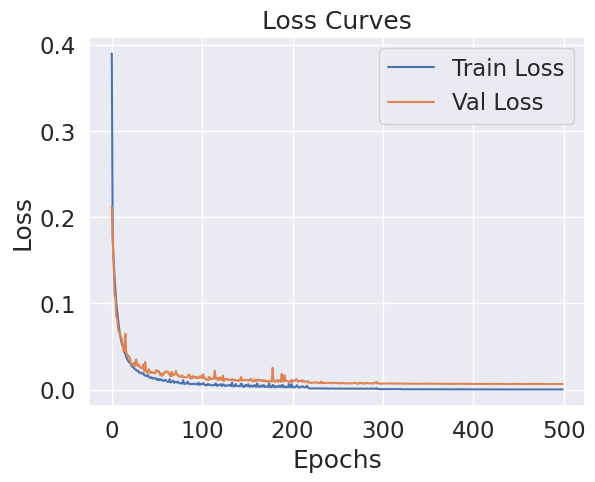

In [ ]:
loss_graph(train_loss_list, val_loss_list)

[[1.         0.99724521]
 [0.99724521 1.        ]]


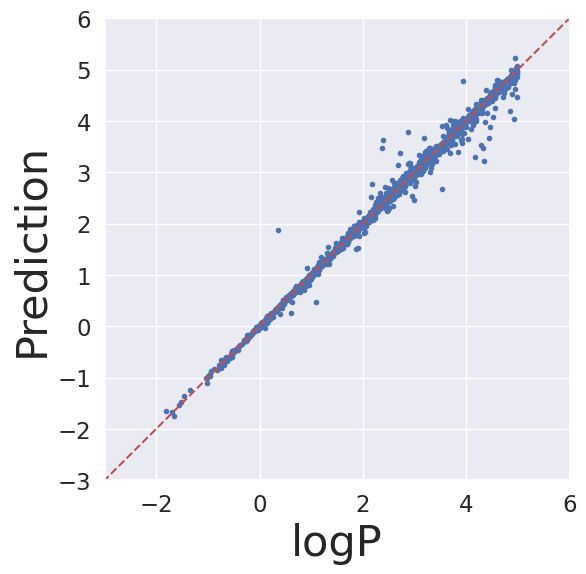

In [ ]:
plot_prediction(y, pred)

In [ ]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,500
test_loss,0.0096
train_loss,0.00034
val_loss,0.00658


# Load trial

In [ ]:
trial.wandb_load_run('dbxms62k')

In [ ]:
trial.upload('GCN_LOGP_TRAIN_best_model_230809.pth')

wandb:   1 of 1 files downloaded.  


[[1.        0.9971663]
 [0.9971663 1.       ]]


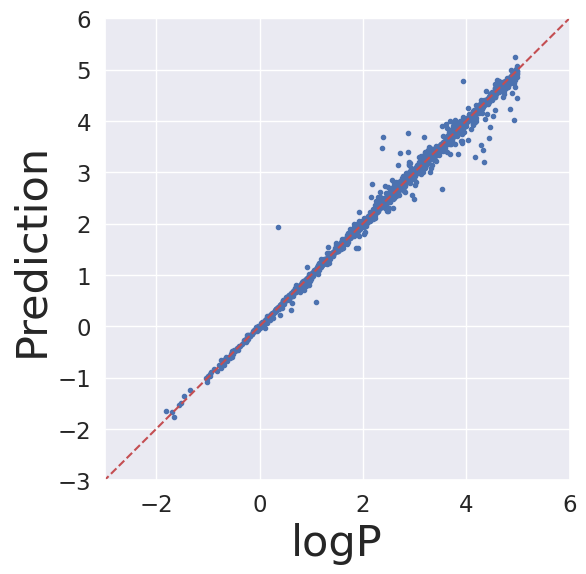

In [ ]:
trial.load_model('rossi22/GCN_LOGP_TRAIN/GCN_LOGP_TRAIN_best_model_230809.pth:v0', from_wandb=True)
test_loss, y, pred = trial.test(test_loader)
plot_prediction(y, pred)

[[1.        0.9971663]
 [0.9971663 1.       ]]


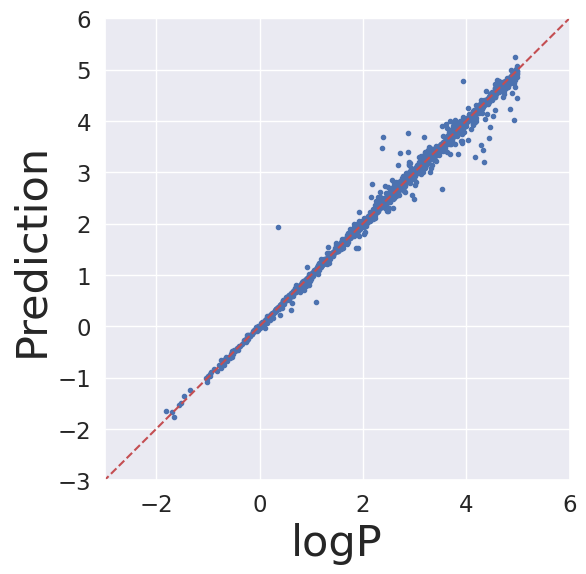

In [ ]:
model_name = 'GCN_LOGP_TRAIN_best_model_230809.pth'
trial.load_model(model_name)

test_loss, y, pred = trial.test(test_loader)
plot_prediction(y, pred)

In [ ]:
wandb.finish()

epoch,500
test_loss,0.00987
train_loss,0.00034
val_loss,0.00658
